# 抽出された特徴量の評価

In [32]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import sklearn.preprocessing
%matplotlib inline


In [33]:
import glob

onomatpeia_list = [
    'clutter', 'gochagocha',
    'murmur', 'sarasara',
    'twinkle', 'kirakira',
]

dat = json.load(open("figure_features.json"))
dirname_list = []

for onomatpeia in onomatpeia_list:
    dirname_pattern = 'jsons/%s/*' % onomatpeia
    for dirname in sorted(glob.glob(dirname_pattern)):
        dirname_list.append(dirname)

shape_pool = np.load('shape_pool.npy')
shape_feat_pool = np.load('shape_feat_pool.npy')

In [54]:
# 楕円傾向の集計

import sklearn.decomposition
import glob
import json

def analyse(points):
    pca = sklearn.decomposition.PCA()
    pca.fit(points)
    transformed = pca.transform(points)
    std = transformed.std(axis=0)
    aspect = std[0] / std[1]
    direction = pca.components_[0]
    return aspect, direction

onomatopeia_list = [
    'clutter', 'gochagocha',
    'murmur', 'sarasara',
    'twinkle', 'kirakira',
]

import os

aspect = []
direction = []
for onomatopeia in onomatopeia_list:
    dirname_pattern = 'jsons/%s/*' % onomatopeia
    for dirname in glob.glob(dirname_pattern):
        filename_pattern = os.path.join(dirname, '*')
        print filename_pattern
        onomatpeia_dat = []
        aspect_ = []
        direction_ = []    
        for filename in sorted(glob.glob(filename_pattern)):
            dic = json.load(open(filename))
            path = dic['vertex']
            a, d = analyse(path)
            if d[0] < 0:
                d *= -1
            d = np.arctan2(d[1], d[0])

            aspect_.append(a)
            direction_.append(d)
        aspect.append(np.array(aspect_))
        direction.append(np.array(direction_))
len(aspect)
len(direction)


jsons/clutter/JPN/*
jsons/clutter/WRD/*
jsons/gochagocha/JPN/*
jsons/gochagocha/WRD/*
jsons/murmur/JPN/*
jsons/murmur/WRD/*
jsons/sarasara/JPN/*
jsons/sarasara/WRD/*
jsons/twinkle/JPN/*
jsons/twinkle/WRD/*
jsons/kirakira/JPN/*
jsons/kirakira/WRD/*


12

In [35]:
# for d, dirname in zip(dat, dirname_list):
#     d = np.array(d)
#     print dirname, "\t", d.mean(0)

In [36]:
feat = np.array([np.array(d).mean(0) for d in dat])

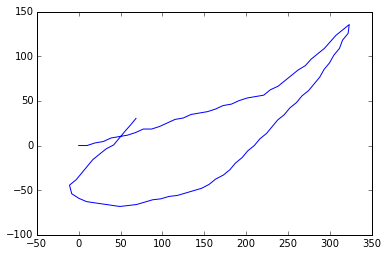

In [37]:
def gen_angle(idx):
    bin_range = 2 * np.pi / 18
    return np.random.random() * bin_range + bin_range * idx - np.pi


def randomwalk(feat, length):
    angle = []
    for i in range(length):
        idx = np.argmax(np.random.multinomial(1, feat))
        angle.append( gen_angle(idx) )
    angle = np.array(angle)
    
    path = gen_path(angle)
    
    return path

def gen_path(angle):
    point = np.zeros(2)
    path = [point.copy()]
    edge_len = 10
    direction = 0
    
    for a in angle:
        dp = np.array([np.cos(direction), np.sin(direction)]) * edge_len
        point += dp
        path.append(point.copy())
        direction += a

    path = np.vstack(path)

    return path


def poolwalk(feat, shape_pool, feat_pool, length):
    feat = np.array(feat)
    feat_pool = np.array(feat_pool)
    shape_pool = np.array(shape_pool)
    dist = np.linalg.norm(feat_pool - feat, axis=1)
    idx = np.argsort(dist)
    num = length / len(shape_pool[0])
    angle = np.hstack(shape_pool[idx][:num][np.random.permutation(num)])
    return gen_path(angle)
    

def plot_path(path, marker=None):
    plt.plot(*path.T, marker=marker)    

plot_path(poolwalk(feat[0], shape_pool[0], shape_feat_pool[0], 100))

In [38]:
def rotate(vec2, theta):
    mat = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]])
    return vec2.dot(mat)
    

In [39]:
def gen_circle(n, radius):
    xs = []
    for i in range(n):
        a = i * np.pi * 2 / n
        xs.append([np.cos(a), np.sin(a)])
    return np.array(xs) * radius

In [67]:
norm = lambda x: sklearn.preprocessing.normalize(x, norm='l1')[0]

def gen_bone(path, sigma):
    window_ = scipy.signal.gaussian(len(path) * 2, sigma)
    def window(x):
        l = len(window_)/2
        return norm(window_[l-x:2*l-x])[:, None]
    bone = np.array([(path * window(i)).sum(0) for i in range(len(path))])
    return bone


def to_circle(path, sigma, radius, aspect, direction):
    bone = gen_bone(path, sigma)
    bone_edge = bone[1:] - bone[:-1]
    
    meat = []

    for i in range(len(path)-1):
        p = path[i] - bone[i]
        e = bone_edge[i]
        arg = np.arctan2(p[1], p[0]) - np.arctan2(e[1], e[0])
        dist = np.linalg.norm(p)
        meat.append([arg, dist])
    
    circle = gen_circle(len(path), radius)
    # 楕円に
    circle[:, 0] *= aspect
    circle = rotate(circle, direction)
    
    circle_edge = circle[1:] - circle[:-1]
    
    circle_path = []
    for i in range(len(path)-1):
        arg, dist = meat[i]
        e = circle_edge[i]
        e = e / np.linalg.norm(e) * dist
        c = circle[i]
        p = c + rotate(e, arg)
        circle_path.append(p)

    circle_path = np.array(circle_path)
    return circle_path


def gen_avarage_shape(feat, shape_pool, feat_pool, length, aspect, direction, sigma=5, radius=200):
    path = poolwalk(feat, shape_pool, feat_pool, length)
    return to_circle(path, sigma, radius, aspect, direction)
#     return path


# 平均図形の生成

In [68]:
sigma = 5
length = 500
radius = 100

In [70]:
len(shape_feat_pool[0])

390

In [73]:
def plot_avarage_shape(num):
    dirname = dirname_list[num]
    feat = np.mean(dat[num], axis=0)
    path = gen_avarage_shape(feat, shape_pool[num], shape_feat_pool[num], length, np.mean(aspect[num]), np.mean(direction[num]), sigma=sigma, radius=radius)

#     path = gen_avarage_shape(feat, shape_pool[num], shape_feat_pool[num], length, 0.1, np.mean(direction[num]), sigma=sigma, radius=radius)

    plt.figure(figsize=(24, 8))
    plt.subplot(1, 4, num % 4 + 1).set_aspect(1)
    plt.plot(*path.T)
    plt.tight_layout()
    plt.title(dirname.replace('jsons/', ''))


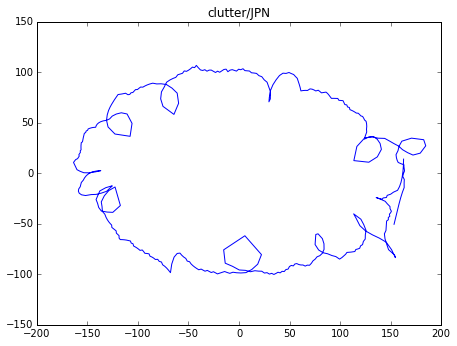

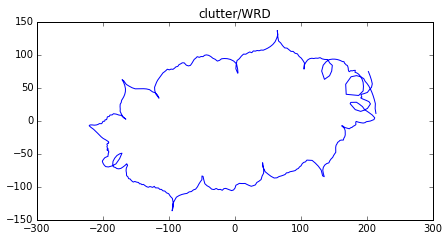

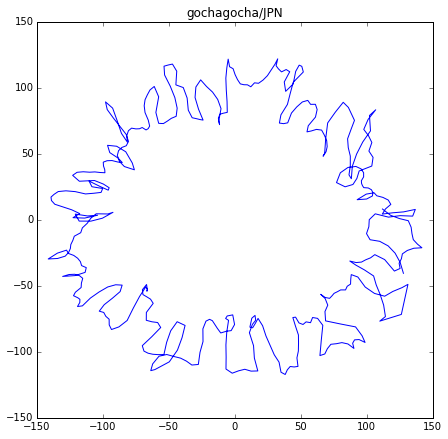

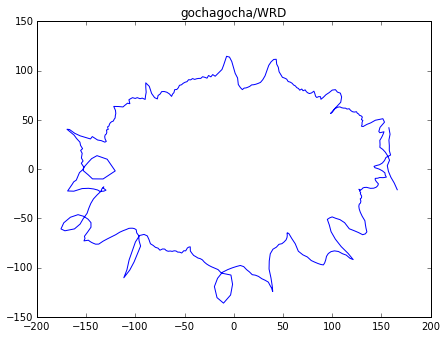

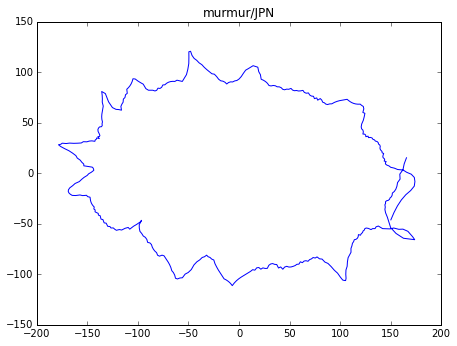

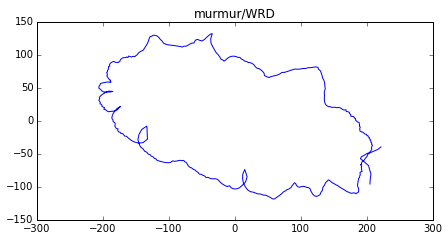

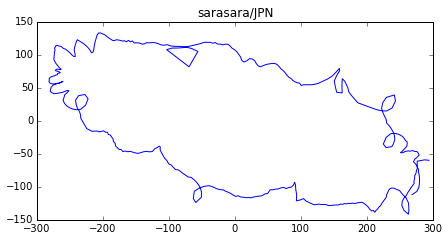

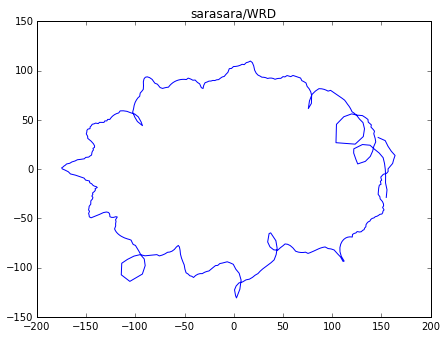

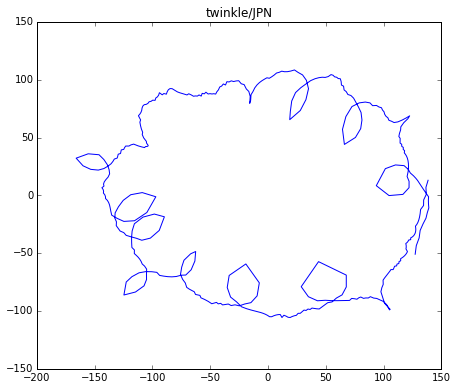

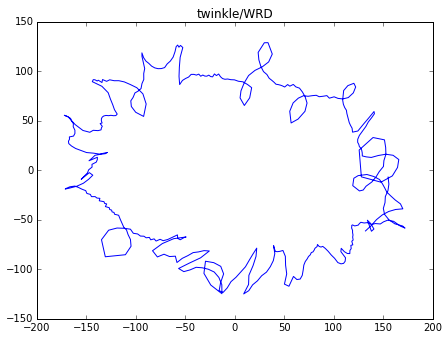

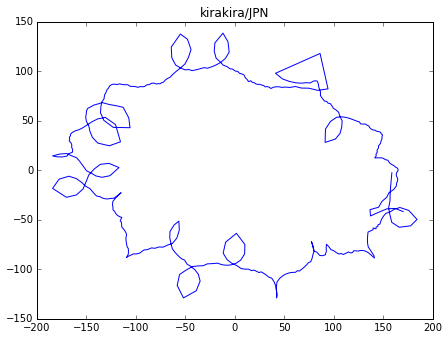

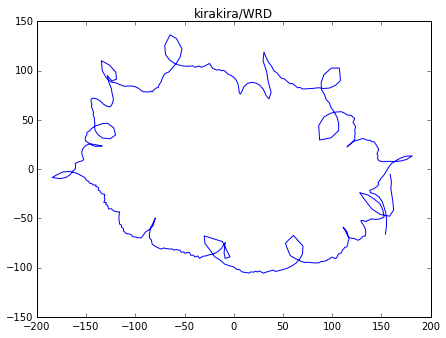

In [74]:
for num in range(0, 12):
    plot_avarage_shape(num)
plt.savefig('avarage_images/avarage-onomatopeia.pdf', format='pdf')

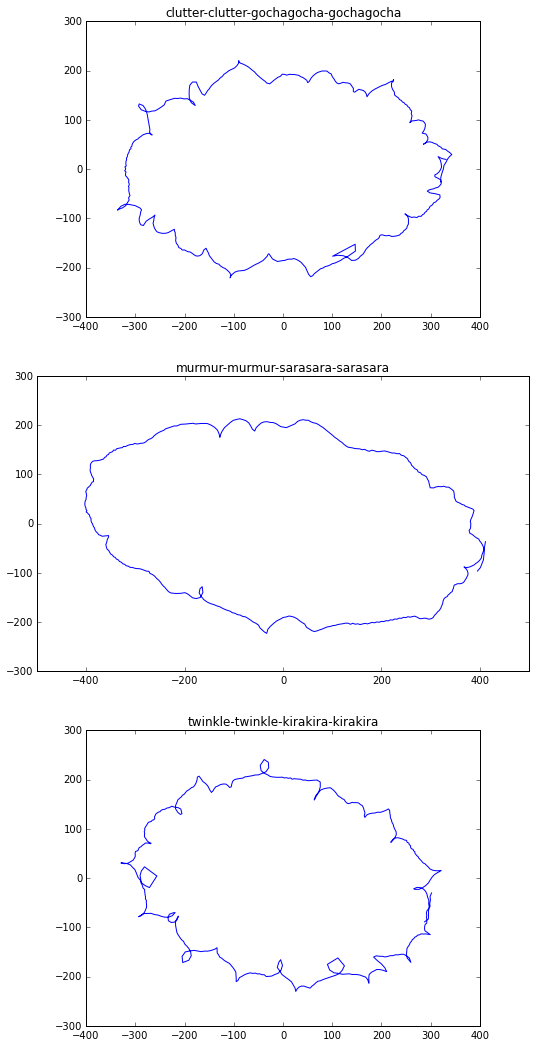

In [88]:
plt.figure(figsize=(12, 18))

for num in range(0, len(dirname_list), 4):
    feat = np.mean(np.vstack(dat[num:num+4]), axis=0)
#     shape = gen_avarage_shape(feat, np.vstack(shape_pool[num:num+4]), np.vstack(shape_feat_pool[num:num+4]), np.hstack(aspect[num:num+4]).mean(), np.mean(np.hstack(direction[num:num+4])), length, sigma=sigma)

    shape = gen_avarage_shape(feat, np.vstack(shape_pool[num:num+4]), np.vstack(shape_feat_pool[num:num+4]), length, np.hstack(aspect[num:num+4]).mean(), np.hstack(direction[num:num+4]).mean(), sigma=sigma)

    plt.subplot(3, 1, num/4+1).set_aspect(1)
    plt.plot(*shape.T)
    dirname = '-'.join(dirname_list[num:num+4]).replace('jsons/', '').replace('/JPN', '').replace('/WRD', '')
    plt.title(dirname)

    
plt.savefig('avarage_images/genshou-avarage.pdf', format='pdf')

